### Perform QA Task using pre-trained large language model (GPT2) which is fine-tuned using the SQuAD Dataset
##### Large pre-trained language models such as GPT can be useful for many natural language tasks other than text generation. In this project, I will take a look at one of such tasks: question-answering (QA).

##### In QA task, the model is given some **context** text and a **question** related to the context. The model is tasked to generate the correct answer based on the context and question. For example, a context could be "Joe enjoys pizza but prefers pasta over anything else", and given a question "What's Joe's favorite food", the model should output "pasta".

Notes:
* To accelerate the training time please use a GPU, you can use Google Colab and choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
* Google Colab is the environment I used to code this project, hence, it will perfrom as intended in the same environment (the tqdm progress bars do not get rendered well in VSCode)

In [ ]:
# In addition to numpy, pytorch, and other standard libraries, you will need the following for this assignment
!pip install transformers datasets

### 1. Initialising the SQuAD Dataset

A popular dataset for question-answering task is the Stanford Question-answering Dataset (SQuAD) ([Rajpurkar, Pranav, et al. "Squad: 100,000+ questions for machine comprehension of text." arXiv preprint arXiv:1606.05250 (2016).](https://arxiv.org/abs/1606.05250)). The code below will automatically download and load the dataset. The training and validation split can be accessed with `squad_dataset['train']` and `squad_dataset['validation']` respectively.

In the following cells, the size of each split as well as one example from each split is printed:

In [ ]:
from datasets import load_dataset
squad_dataset = load_dataset("squad")

####################################################################################
# Train set details:
print(f"Train split: {squad_dataset['train'].num_rows} samples")
train_sample = squad_dataset["train"][0]
print(f"Sample id: {train_sample['id']}")
print(f"Context: {train_sample['context']}")
print(f"Question: {train_sample['question']}")
print(f"Answer: {train_sample['answers']['text'][0]}")
####################################################################################
print()
####################################################################################
# Validation set details:
print(f"Validation split: {squad_dataset['validation'].num_rows} samples")
validation_sample = squad_dataset["validation"][0]
print(f"Sample id: {validation_sample['id']}")
print(f"Context: {validation_sample['context']}")
print(f"Question: {validation_sample['question']}")
print(f"Answer: {validation_sample['answers']['text'][0]}")
####################################################################################

  0%|          | 0/2 [00:00<?, ?it/s]

Train split: 87599 samples
Sample id: 5733be284776f41900661182
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous

Validation split: 10570 samples
Sample id: 56be4db0acb8001400a502ec
Context: Super Bowl 50 was an American footbal

### 1.2 Extending GPT2 for question-answering task
In this part, I shall extend the GPT2 model to produce answers from the context based on the questions. To make use of the pre-trained GPT2 model, I will treat it as a feature extractor to compute token-wise feature vectors and add additional MLP layers to process the features for the QA task.

Notes:
* I have used a classifcation approach rather than a regression, where I classify the start and end locations of the answer. For example, given a input text of length 5 after tokenization, suppose the answer starts at token `2` and ends at token `4`, the model should predict `[0 0 1 0 0]` and `[0 0 0 0 1]` as the start and end location respectively.
* Unlike image data, text input can have varying length, which makes batch training and loss computation more challenging. So, for simplicity, I have assumed the batch size to be 1 in this question. I.e., the `question`, `context` and `answer` belong to a single sample in the dataset.

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2Model

class GPT2QuestionAnswering(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')

        # Add additional layers for predicting the location of the answer
        self.start_index_classifier = nn.Linear(self.gpt2.config.n_embd, 1)
        self.end_index_classifier = nn.Linear(self.gpt2.config.n_embd, 1)

    def forward(self, question, context, answer=None):
        inputs = self.tokenizer(question, context, return_tensors='pt', return_offsets_mapping=True)
        input_ids = inputs.input_ids[:,:self.gpt2.config.n_positions]
        attention_mask = inputs.attention_mask[:,:self.gpt2.config.n_positions]
        if torch.cuda.is_available:
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
        features = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        # Using the additional layers to compute location of the answer based on the hidden state features
        start_index_prob = self.start_index_classifier(features).squeeze()
        end_index_prob = self.end_index_classifier(features).squeeze()

        if self.training:

            return self.loss(start_index_prob, end_index_prob, inputs, answer)
        else:

            answer_start_index = start_index_prob.argmax().item()
            answer_end_index = end_index_prob.argmax().item()

            return self.tokenizer.decode(inputs.input_ids[0, answer_start_index : answer_end_index + 1]).strip()

    def loss(self, start_index_prob, end_index_prob, inputs, answer):
        # Compute the loss based on the answers

        actual_answer_index = (answer["answer_start"][0], answer["answer_start"][0] + (len(answer["text"][0]) - 1))

        actual_start_token = 0
        actual_end_token = 0

        for i,token_index in enumerate(inputs.offset_mapping[0]):

          if token_index[0] <= actual_answer_index[0] < token_index[1]:
            actual_start_token = i

          if token_index[0] <= actual_answer_index[1] < token_index[1]:
            actual_end_token = i

        target_start = torch.zeros_like(start_index_prob)
        target_start[actual_start_token] = 1
        target_end = torch.zeros_like(end_index_prob)
        target_end[actual_end_token] = 1

        loss_func = nn.CrossEntropyLoss()

        start_loss = loss_func(start_index_prob, target_start)
        end_loss = loss_func(end_index_prob, target_end)

        return ((start_loss + end_loss) / 2)

I can evaluate the pre-trained model's performance on the validation split. Since the model has not been adapted to the question-answering task yet, and additional untrained layers have been added, it is expected that the model perform poorly.

In question-answering task, I use two evaluation metrics:
* **Exact match**: the percentage of predictions that match the ground truth answer exactly
* **F1 score**: the average overlap (in terms of tokens) between the prediction and ground truth answer

Higher values are better for both metrics. For reference, humans can achieve 77.0% exact match and 86.8% F1 score, while SOTA method achieves 90% exact match and over 95% F1 score.

In [ ]:
def evaluate(model, dataset, metric):
    from tqdm.autonotebook import tqdm
    model = model.eval()
    preds = []
    for idx, data in enumerate(tqdm(dataset['validation'])):
        preds.append(dict(id=data['id'], prediction_text=model(data['question'], data['context'], data['answers'])))
    references = [dict(answers=data['answers'], id=data['id']) for data in dataset['validation']]
    return metric.compute(predictions=preds, references=references)

In [ ]:
from datasets import load_metric

squad_metric = load_metric('squad')
model = GPT2QuestionAnswering()
if torch.cuda.is_available:
    model = model.cuda()

evaluate(model, squad_dataset, squad_metric)

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 0.04730368968779565, 'f1': 2.7868297662395216}

### 1.3 Fine-tuning GPT2 on Squad
To adapt a pre-trained model to a specific downstream task (in this case the question-answering task), a common technique is to **"fine-tune"** the model. Fine-tuning simply means training the model using task-specific data, typically with shorter epochs and smaller learning rates. Certain part of the model (e.g., pre-trained layers or early layers) can also be frozen, meaning the weights are not updated during training.

In this part, I will fine-tune the model on SQuAD dataset.<br>

**Note:** due to the size of the model and dataset, the training shall be performed only for half of the dataset (however, the improvement in accuracy can still clearly be seen)

##### Future Improvement Plans:
* **Freezing GPT2 Layers:** The pre-trained GPT2 layers could be chose to be "frozen" during fine-tuning
* **Gradient Accumulation:** The model from previous question is not suitable for batch training, which could increase the stochasiticy of the training process and make convergence slower. One way to circumvent this problem is via gradient accumulation, wherein the gradient is accumulated for multiple iterations before the weights are updated, which increases the effective batch size.

In [ ]:
from tqdm.autonotebook import tqdm
losses = []

num_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_rows = squad_dataset['train'].num_rows

model = model.train()
for e in range(num_epochs):
    # Shuffle dataset in each epoch
    indices = torch.randperm(num_rows)
    indices = indices.tolist()

    # tqdm gives us a nice little progress bar
    pbar = tqdm(indices)
    for i, idx in enumerate(pbar):
        
        # Obtain data from training split
        data = squad_dataset['train'][idx]
        question = data["question"].strip()
        context = data["context"].strip()
        loss = model(question, context, data['answers'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss values
        if (i % 100) == 0:
          losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/87599 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Plotting the loss values over the iterations.

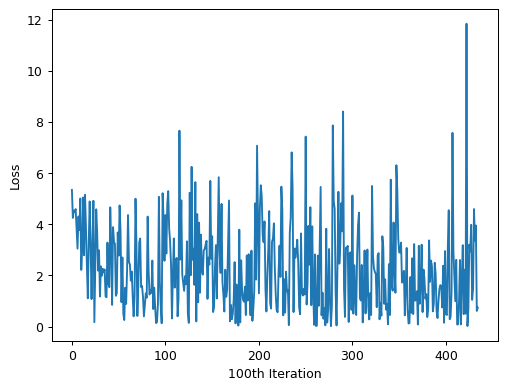

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=90)
plt.plot(losses)
plt.xlabel('100th Iteration')
plt.ylabel('Loss')
plt.show()

Evaluating the model performance after fine-tuning. It can be seen that a much higher score is obtained compared to the previous results.

In [ ]:
evaluate(model, squad_dataset, squad_metric)

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 49.290444654683064, 'f1': 61.275921458021884}

This model can now be used for QA requirements using the below format

In [ ]:
model('Your question', 'Your context')